<a href="https://colab.research.google.com/github/DanGlado/0_git_basics/blob/master/%5B12%5D_Skip_gram_Word2Vec_(Exercises).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skip-gram Word2Vec

Разберёмся с реализацией алгоритма [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) с использованием skip-gram архитектуры (“словосочетание с пропуском”. Мы пытаемся из данного нам слова угадать его контекст, точнее - вектор контекста).

Отметим, что векторные представления (embeddings) используются только для слов. Их можно использовать для любых моделей, где присутствует большое количество классов. Одна из реализаций модели нейронной сети называется **Word2Vec** и использует слой embedding, чтобы найти векторное представление слова, которое будет сохранять семантический смысл.

В данной реализации skip-gram архитектура используется вместе с negative sampling, так как такая комбинация работает быстрее, чем CBOW.

[Отличная статья на Хабр про Embedding и способы реализации](https://habr.com/ru/companies/ods/articles/329410/)

### Negative Sampling

В стандартной модели CBoW, рассмотренной выше, мы предсказываем вероятности слов и оптимизируем их. Функцией для оптимизации (минимизации в нашем случае) служит дивергенция Кульбака-Лейблера:

$$KL(p||q) = \int{p(x) log\frac{p(x)}{q(x)}} dx$$


Здесь $p(x)$ — распределение вероятностей слов, которое мы берем из корпуса, $q(x)$ — распределение, которое порождает наша модель. Дивергенция — это буквально "расхождение", насколько одно распределение не похоже на другое. Т.к. наши распределения на словах, т.е. являются дискретными, мы можем заменить в этой формуле интеграл на сумму:

$$KL(p||q) = \sum_{x \in V}{p(x) log\frac{p(x)}{q(x)}}$$


Оказалось так, что оптимизировать эту формулу достаточно сложно. Прежде всего из-за того, что $q(x)$ рассчитывается с помощью softmax по всему словарю. (Как мы помним, в английском сейчас порядка миллиона слов.) Здесь стоит отметить, что многие слова вместе не встречаются, как мы уже отмечали выше, поэтому большая часть вычислений в softmax является избыточной. Был предложен элегантный обходной путь, который получил название Negative Sampling. Суть этого подхода заключается в том, что мы максимизируем вероятность встречи для нужного слова в типичном контексте (том, который часто встречается в нашем корпусе) и одновременно минимизируем вероятность встречи в нетипичном контексте (том, который редко или вообще не встречается). Формулой мысль выше записывается так:

$$NegS(w_o) = \sum_{i=1, x_i \thicksim D}^{i=k}{-log(1 + e^{s(x_i, w_o)})} + \sum_{j=1, x_j \thicksim D'}^{j=l}{-log(1 + e^{-s(x_j, w_o)})}$$


Здесь $s(x,w)$ — точно такой же, что и в оригинальной формуле, а вот остальное несколько отличается. Прежде всего стоит обратить внимание на то, что формуле теперь состоит из двух частей: позитивной ($s(x,w)$) и негативной ($-s(x,w)$). Позитивная часть отвечает за типичные контексты, и $D$ здесь — это распределение совместной встречаемости слова $w$ и остальных слов корпуса. Негативная часть — это, пожалуй, самое интересное — это набор слов, которые с нашим целевым словом встречаются редко. Этот набор порождается из распределения $D'$, которое на практике берется как равномерное по всем словам словаря корпуса. Было показано, что такая функция приводит при своей оптимизации к результату, аналогичному стандартному softmax [2].

## Шаг 1. Загрузка данных

Заружаем по ссылке данные - [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip) - статья из *Wikipedia article text* от Matt Mahoney.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from os import read
# read in the extracted text file
with open('/content/drive/MyDrive/Нейросети_Дисциплина/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Шаг 2. Предобработка данных

Функция `preprocess` делает несколько операций:
* Конвертирует каждый знак пунктуации в токен, также заменяет на служебные слова ` <PERIOD> , <COMMA>` и т.д.
* Удаляет слова, которые встречаются пять или меньше раз, что существенно улучшает работу модели за счёт удаления шумов.
* Возвращает список слов, которые встречаются в модели.

In [18]:
import re
from collections import Counter

In [19]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()

    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [20]:
# get list of words
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [21]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


## Шаг 3. Создание словарей

Для создания двух словарей, устанавливающих соответствие между словами и числами, используется функция `create_lookup_tables`: отметим, что числа назначаются в порядке убывания частоты, то есть наиболее часто встречающееся слово "the" соответствует числу 0, следующее по частоте встречаемости слово "of" соотвутствует 1 и т.д.

In [22]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

При помощи словарей используемые в тексте слова конвертируются в числа и эти числа сохраняются в список `int_words`.

In [23]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Шаг 4. Подвыборка (subsampling)

Часто встречающиеся слова, такие как "the", "of", "for" не задают какой-либо значимый контекст для своих слов-соседей. Если их убрать из тренировочного множества, то можно ускорить работу модели и получить лучшие результаты. Томаш Миколов назвал этот процесс subsampling. Для каждого слова $w_i$ в тренировочном множестве определим вероятность его встречи:
$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}, $$

где $t$ - это порог встречаемости, а $f(w_i)$ - частота встречаемости слова $w_i$ в итоговом наборе данных.

Например, вероятность встретить нулевое слово "the":
$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

> Проделаем подвыборку для слов из множества `int_words`. Для каждого слова из множества `int_words` посчитаем указанную вероятность $P(w_i)$, которая будет показывать, что слово стоит убрать из рассмотрения. Итоговый результат - отобранные слова - сохраним в множество `train_words`.

In [24]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0:4])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count / total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold / freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[(5233, 303), (3080, 572), (11, 131815), (5, 325873)]
[3133, 741, 10571, 27349, 854, 15067, 58112, 150, 3580, 10712, 1324, 104, 362, 26, 53, 2757, 18, 7088, 5233, 44611, 5233, 602, 1134, 19, 2621, 8983, 4147, 6437, 4186, 362]


## Шаг 5. Составление  батчей

Теперь данные приведены в хороший вид, но осталось привести их к виду, который будет удобен для подачи в нейронную сеть. В skip-gram модели для каждого слова из текста необходимо определить окружающий его _контекст_ и взять все слова вокруг, остоящие на заданное расстояние, не превосходящее $C$.

[Оригинальная статья Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf) содержит следующее пояснение:

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

"Поскольку слова, наиболее удалённые от заданного, менее связаны с рассматриваемым словом, будем присваивать меньший вес более удалённым словам и больший вес более близким словам из наших тренировочных примеров... Если мы выберем $C = 5$, для каждого тренировочного слова будем случайно выбирать число $R$ из диапазона $[ 1: C ]$, а затем использовать $R$ слов, идущих до данного слова, и $R$ слов, стоящих после данного слова, и все эти слова будем формировать в правильные метки."

Создадим функцию `get_target`, которая будет получать на вход последовательность слов, индекс, размер окресности, а на выходе будет выдавать список слов, расположенных в заданной окрестности.

In [25]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''

    R = np.random.randint(1, window_size + 1)
    start = max(0, idx - R)
    stop = min(len(words), idx + R + 1)
    target_words = set(words[start:idx] + words[idx+1:stop])

    return list(target_words)

**Задание:** Пусть мы получили последовательность
```
train_words = [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```
Какой результат будет после применения функции `get_target` для `R=2` к токену с порядковым номером 2?


In [26]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5# word index of interest

target =  get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]


Теперь создадим функцию, которая будет создавать батчи для входных и целевых значений, с использованием функции `get_target`. Параметр `batch_size` отвечает за количество слов, которые будут брать из данного множества для формирования батча.

In [27]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''

    n_batches = len(words) // batch_size

    # only full batches
    words = words[:n_batches*batch_size]

    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y


In [28]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 1, 1, 1, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 3, 1, 3, 0, 1, 2]


## Шаг 6. Проверка

Для проверки точности предсказаний модели используется косинусное сходство:

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


Можно закодировать слова из проверочного множества как векторы $\vec{a}$ с использованием технологии таблиц embedding, потом посчитать косинусное сходство с каждым вектором $\vec{b}$ из той же таблицы embedding. Таким образом, мы можем сравнить проверочные слова и слова, полученные при группировании посредством косинусного расстояния, и понять, насколько хорошо модель группирует слова с учётом их семантической близости.

In [29]:
import torch

In [31]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """

    # Here we're calculating the cosine similarity between some random words and
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.

    # sin = (a * b) / |a||b|

    embed_vectors = embedding.weight

    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)

    valid_vectors = embed_vectors[valid_examples]
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes

    return valid_examples, similarities

## Шаг 7. SkipGram model

Создадим и натренируем SkipGram model.
> Нам необходимо определить [слой embedding](https://pytorch.org/docs/stable/nn.html#embedding) и итоговый, выходной слой с функцией softmax.

Embedding слой принимает количество входных значений:
* **num_embeddings** – размер словаря embedding, или сколько строк небходимо для матрицы весов embedding;
* **embedding_dim** – размер каждого вектора embedding; размерность embedding.

Компоненты векторов слоя Embedding являются обучаемыми параметрами. Для них (как и для любых параметров) можно установить ограничения значений и регуляризационные довески к ошибке.

<img src = 'https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/c9404fc86181fc3f0906b368697268257f348535/word2vec-embeddings/assets/skip_gram_arch.png'>

Обращаем внимание на следующие моменты:

>* входные слова переводятся в токены и токены формируются в батчи;
>* батчи пропускают сквозь скрытый линейный слой - слой embedding;
>* результаты передаются в выходной слой с функцией активации softmax.



Слой softmax необходим для того, чтобы получить вероятность предсказанного слова, сделанную на основании контекста.

## Negative Sampling

Для каждого примера, который мы подаём на вход нейронной сети, в качестве обучения используется значение после выходной слоя с функцией softmax. Это означает, что для каждого одного входного значения, мы сделаем незначительные изменения для миллионов весов. Это очень неэффективно. Поэтому было придумано решение - обновлять веса не с использованием верных примеров, а для небольшого множества шумов. Другими словами, задача от противного - обучение нейронной сети видеть неправильные примеры. Этот метод получил название ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Сделаем две модификации:
1. будем рассматривать не все слова сразу, а по одному слову за единицу времени. Как и в случае с использованием таблицы embedding для установления соответствия между входным словом и скрытым состоянием, мы сейчас можем использовать другую embedding таблицу для установсления соответствия между скрытым слоем и выходным значением. То есть у модели будет два слоя embedding - для входного и для выходного слова.
2. будем использовать немного модифицированную функцию потерь с учётом идеи обучения на шумовых данных:
$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

Здесь $u_{w_O}\hspace{0.001em}^\top$ - embedding вектор для выходного целевого слова ($^\top$ - транспонирование) и $v_{w_I}$ - embedding вектор для входного слова.

Тогда выражение
$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$
означает, что мы берём log-sigmoid скалярного произведения выходного и входного вектора.

Далее возьмём сумму по всем шумовым словам $w_i$ из распределения $w_i \sim P_n(w)$:
$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$

Распределение шума по сути является словарём из слов, которые не входят в контекст данного входного слова. То есть для получения шумовых слов мы можем просто случайным образом выбирать слова из нашего словаря. Но $P_n(w)$ — произвольное распределение вероятностей, поэтому необходимо понять, каким образом задавать веса для каждого слова. Это может быть равномерное распределение, при котором мы выбираем все слова с равной вероятностью. Или можно задатьт униграммное распределение $U(w)$, которое будет показывать частоту встречаемости каждого слова из словаря. Авторы эмпирически пришли к наилучшему варианту, равному $U(w)^{3/4}$.

Итого слагаемые в нашей сумме будем умножать на

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$

И в результате получим функцию потерь:

<img src="https://media.githubusercontent.com/media/TeoZosa/deep-learning-v2-pytorch/master/deep_learning_v2_pytorch/word2vec-embeddings/assets/neg_sampling_loss.png">


Здесь первое слагаемое показывает, что наша модель будет предсказывать верные слова $w_O$ с вероятностью 1, а второе слагамое - что модель будет предсказывать неверные слова с вероятностью 0.

In [32]:
import torch
from torch import nn
import torch.optim as optim

In [33]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()

        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist

        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)

        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)

    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors

    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors

    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = torch.tensor(self.noise_dist)

        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)

        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)

        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)

        return noise_vectors

In [38]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):

        batch_size, embed_size = input_vectors.shape

        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)

        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)

        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.unsqueeze(dim=1).sum(1)

        # incorrect log-sigmoid loss
        noise_loss =torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

## Шаг 8. Тренировка модели


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(word_counts.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):

    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)

        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

<ipython-input-33-6dedc08bb8df>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_dist = torch.tensor(self.noise_dist)


Epoch: 1/5
Loss:  6.97240686416626
its | the, after, kropotkin, kolkata, charges
th | royal, radio, electrically, affix, israel
war | overhang, pierre, organising, scripture, pairing
had | of, royce, the, targets, english
when | of, world, mathematical, walking, the
his | of, chancellor, paramilitary, complaints, include
to | the, of, for, as, one
than | reunited, funny, thrown, jennifer, signal
universe | common, unilateral, disapproval, petition, manic
marriage | son, web, viscosity, sabbath, proportionality
bbc | chord, southwest, octahedron, effected, massive
issue | collegiate, francesco, russia, territorial, cotopaxi
behind | roc, unethical, joins, job, frawley
question | supply, embodiment, anything, capella, flea
something | tentacles, bolstered, reviews, participants, mobilization
institute | babel, apoptotic, borough, hop, holding
...

Epoch: 1/5
Loss:  5.00454568862915
b | stateless, push, mankind, banned, been
united | two, a, appearance, one, embraced
years | the, nine, fo

## Шаг 9. Визуализация полученных векторов

Для визуализации будем использовать готовый алгоритм Стохастического вложения соседей с t-распределением T-SNE (t-distributed Stochastic Neighbor Embedding), который позволяет хорошо проецировать многомерные пространства на двумерную плоскость:
Подробнее: [применение Christopher Olah для визуализации MNIST](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

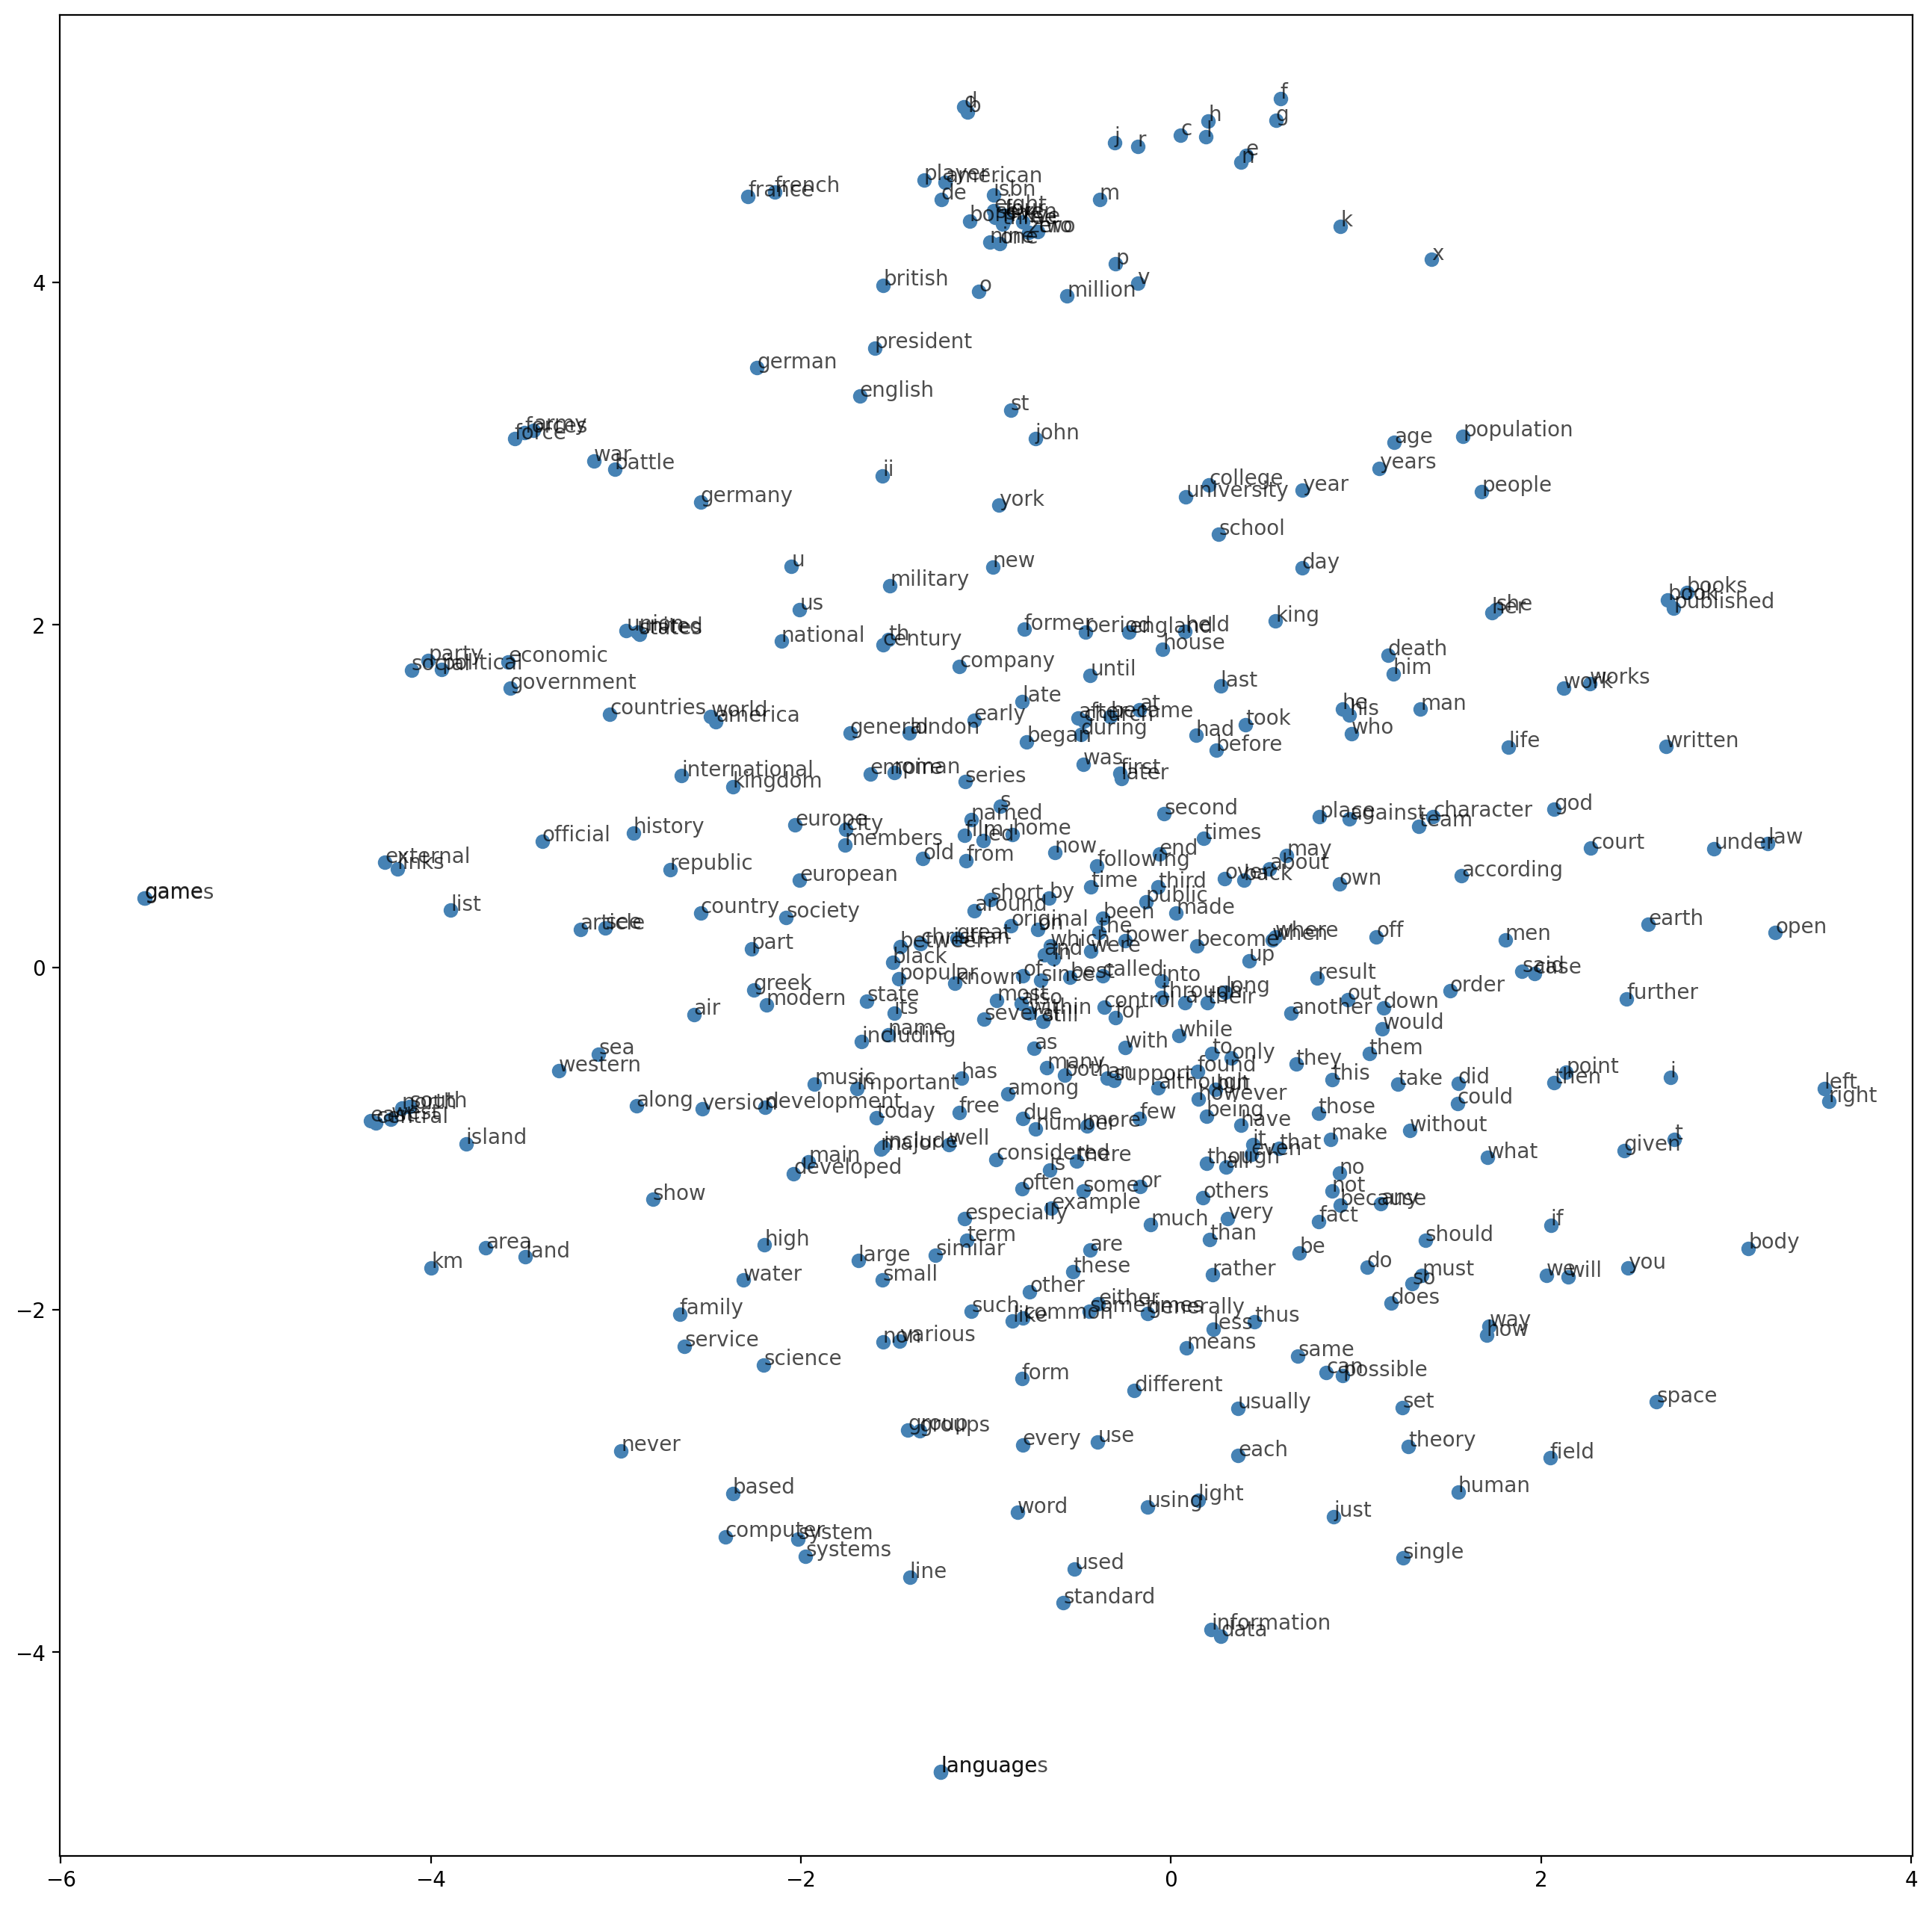

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Задание:  реализовать базовую SkipGram model и сравнить результаты.

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()

        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embeds = self.embed(x)
        out = self.output(embeds)
        log_probs = self.log_softmax(out)

        return log_probs


## Дополнительная литература:

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.